**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

---

Mentoría #13 - Cómo hacer un Clasificador de Pliegos todoterreno (y de otros tipos de textos) usando NLP

---
Integrantes Grupo [1|2]:
*   Sofia Gazzoni:   sofigazzoni@gmail.com
*   Santiago Rosa:   santiago.rosa@mi.unc.edu.ar
*   Franco Manini:   franco.manini@mi.unc.edu.ar
*   Gonzalo Tizeira: gontizeira@gmail.com

Edición 2023


# Introducción

En esta Mentoría, trabajaremos con un conjunto de datos que comprende aproximadamente 100.000 pliegos y licitaciones de diversos organismos nacionales, tanto públicos como privados. Estos datos se obtuvieron de un sistema/servicio diseñado para monitorear oportunidades de negocios, capturar la información en una base de datos, normalizarla y, posteriormente, clasificarla para informar a los usuarios según sus áreas de interés. Los usuarios de este sistema reciben alertas automáticas cada vez que se publica una oportunidad comercial que coincide con su perfil.

## Desafío

Como parte del proceso de clasificación, los pliegos se etiquetan utilizando principalmente reglas estáticas, como palabras clave, lo cual deja margen para optimizaciones. El título de cada pliego y principalmente la descripción de los objetos que se están licitando son campos de tipo texto y escritos por personas, por lo que naturalmente presentan ambigüedades y características propias del lenguaje que llevan a que un enfoque rígido y estático de clasificación, como el actual, resulte limitado y poco eficiente.

El Desafío es utilizar las técnicas de Aprendizaje Automático, logrando así un "Clasificador" que utilice técnicas de Procesamiento de Lenguaje Natural (NLP) para clasificar de manera más eficiente en qué rubro o categoría se encuentra un pliego, basándose en su texto descriptivo y otros campos relacionados.

## Interés General

Más allá de la aplicación específica en este conjunto de datos, este problema, al estar vinculado al Procesamiento de Lenguaje Natural (PLN) y la clasificación, tiene la ventaja de poder ser utilizado posteriormente para otros tipos de contenido. De esta manera, el clasificador desarrollado podría aplicarse para categorizar libros, noticias, textos, tweets, publicaciones, artículos, etc.

## Descripción del dataset

A continuación se enumeran las diferentes variables del dataset, así como una breve descripción de su significado:

- **id**: Clave única y primaria autoincremental de la tabla;
- **cargado**: Fecha de carga del pliego;
- **idexterno**: Id del pliego en la fuente;
- **referencia**: Campo auxiliar obtenido de la fuente;
- **objeto**: Campo principal, descripción del producto o servicio objeto de la licitación;
- **rubro**: Campo de categorización disponible en la fuente. No siempre está disponible;
- **agencia**: Empresa o Ente que lanza la licitación;
- **apertura**: Fecha de apertura del pliego (vencimiento para presentarse al pliego);
- **subrubro**: Subcategoría del pliego (también obtenido desde la fuente);
- **pais**: País donde se lanza la licitación;
- **observaciones**: Campo auxiliar donde se guardan datos extra que puede variar según la fuente;
- **monto**: Monto del pliego, no siempre está publicado;
- **divisaSimboloISO**: Moneda en la que se especifica el pliego;
- **visible**: campo binario que determina si el pliego va a ser visualizado por el sistema (True/False);
- **categoría**: Tipo de pliego, categorización entre diversos tipos de pliegos (Compra Directa, Licitación Simple, Subasta, etc.);
- **fuente**: Fuente de donde se obtuvo la licitación.

## Ejercicio 3: Variable [objeto]

1.   Aplicar técnicas de lematización para eliminar artículos, conectores, stop_words en general. Quitar acentos (tildes), mayúsculas, plurales, caractéres inválidos, abreviaturas, etc., dejando solo palabras importantes para la clasificación.
2.   Utilizar técnicas de visualización para detectar otros términos muy frecuentes que no aportan valor a la clasificación.
3.   (Opcional) Aplicar técnicas de tokenización para convertir la variable objeto en un array de tokens.

## Ejercicio 4: Exportación

Con el dataset ya transformado, generar una versión final y exportarla a un nuevo archivo. Este es el resultado final del TP2.

# Desarrollo

In [1]:
import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_rows', None)

df = pd.read_csv("./datos/Mentoria_Dataset_0.csv" , encoding='latin-1')

In [2]:
#En el practico 1 decidimos descartar los datos que tienen categoría 2:
#Descarto los que tienen categoria 2
df_fil = df[df['categoria']==1]

#Variables que decidimos relevantes en el práctico pasado: 
variables = ['referencia', 'objeto', 'rubro','agencia','apertura','monto','fuente']

#Filtro el dataframe con estas variables:
df_fil = df_fil[variables]

In [3]:
#Hacemos el filtrado de fechas hecho en el práctico anterior:
today_date = pd.Timestamp.today().date()
min_date = pd.to_datetime('13/12/2015')
df_fil.reset_index(inplace=True)  #reseteo indices, es util cuando indice=nro de fila

#Fechas malas que encontramos:
fecha_mala1 = df_fil['apertura'][62]
fecha_mala2 = df_fil['apertura'][2025]
fecha_mala3 = df_fil['apertura'][11907]

#Removemos las fechas malas
df_fil = df_fil.drop(df_fil[df_fil['apertura'] == fecha_mala1].index)
df_fil = df_fil.drop(df_fil[df_fil['apertura'] == fecha_mala2].index)
df_fil = df_fil.drop(df_fil[df_fil['apertura'] == fecha_mala3].index)

#Convierto a formato datetime
df_fil['apertura'] = pd.to_datetime(df_fil['apertura'],format='%d/%m/%Y %H:%M')
df_fil['apertura'] = df_fil['apertura'].dt.tz_localize(None)
df_fil['apertura'] = df_fil['apertura'].dt.date

#Removemos outliers
df_fil = df_fil.drop(df_fil[df_fil['apertura'] > today_date].index)
df_fil = df_fil.drop(df_fil[pd.to_datetime(df_fil['apertura']) < min_date].index)


In [4]:
#Precio del dolar oficial
dolar_value = 255

df_fil['monto'] = df_fil['monto'].replace(r'\N', np.nan)
df_fil['monto'] = df_fil['monto'].replace('0', 0)

#Remuevo las strings de espacios, pesos y dolares donde las haya. Cambio la representacion de string a float
j=0
for monto, i in zip(df_fil['monto'],df_fil.index):
    if " " in str(monto):
        df_fil['monto'][i] = str(df_fil['monto'][i]).replace(' ','')
    if "$" in str(monto):
        df_fil['monto'][i] = str(df_fil['monto'][i]).replace('$','')
    if "." in str(monto):
        df_fil['monto'][i] = str(df_fil['monto'][i]).replace('.','')
    if "," in str(monto):
        df_fil['monto'][i] = str(df_fil['monto'][i]).replace(',','.')    
    if "U$S" in str(monto):
        df_fil['monto'][i] = str(df_fil['monto'][i]).replace('US','')
        #convierto a pesos y reemplazo la entrada
        df_fil['monto'][i] = float(df_fil['monto'][i]) * dolar_value  
        j+=1
    df_fil['monto'][i] = float(df_fil['monto'][i]) 
        

**Ejercicio 3:**

a- Aplicar técnicas de lematización para eliminar artículos, conectores, stop_words en general. Quitar acentos (tildes), mayúsculas, plurales, caractéres inválidos, abreviaturas, etc., dejando solo palabras importantes para la clasificación.

b- Utilizar técnicas de visualización para detectar otros términos muy frecuentes que no aportan valor a la clasificación.
    
c- (Opcional) Aplicar técnicas de tokenización para convertir la variable objeto en un array de tokens.


donde aplicar la limpieza:
* objeto
* rubro

**Ejercicio 3: Variable [objeto]**



Empezamos viendo de forma general la distribución de palabras que hay en la variable **objeto**, viendo las primeras entradas del dataset para tener una idea. 

Notamos que:
* Las entradas están llenas de signos de puntuación.
* Hay muchos artículos y conectores.
* Muchas palabras repetidas por estar algunas en mayúsculas, otras en minúsculas, y otras pueden estar abreviadas.
* Muchas palabras son las mismas y sólo cambian si están en singular y plural.

Para tener una idea más detallada, usamos la librería `wordcloud`:

0          Provisión de Insumos (Malla quirurgica, etc.)
1      SERV.DE RECOLECCION, TRANSPORTE, TRATAMIENTO Y...
2                                 REPARACION DE CAMILLAS
3      POLICUBETA PARA DETERMINACION DE HEMOGLOBINA -...
4      p432- Adquisición de insumos para el servicio ...
5        p13-insumos para traumatologia pte Quispe Ochoa
6      JEFA DTO. SALUD Y SEGURIDAD EN EL TRABA.lo - I...
7               ATOSIBAN-CONTRATACIÓN MENOR-PEDIDO 33832
8             ADQUISICIÓN DE SUTURAS - DPTO. QUIRÚRGICO.
9      ADQUISICIÓN DE REACTIVOS PARA RICKETTSIA Y BAR...
10              ADQUISICIÓN DE REACTIVOS PARA VIROLOGÍA.
11     Servicios de Conectividad de Datos en sedes De...
12     SERVICIO DE REPARACION INTEGRAL DE EQUIPOS  DE...
13                      REACTIVOS VIRUS HEPATITIS B-ANTI
14     Servicio profesional de supervisión integral d...
15     Prov. de Equipamiento Deportivo de Accesorios ...
16     OBRAS NUEVAS Y DE MANTENIMIENTO en SARMIENTO 3...
17                             

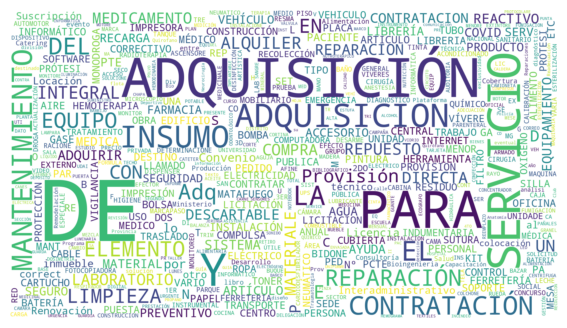

In [5]:
import string
import wordcloud

#defino una función para plotear cloudwords:
def plot_cloudword(data,name):
    entire_words = "".join(item for item in str(data))
    fig=plt.figure(figsize=(10,4))
    ax=fig.add_subplot(111)
    wc = wordcloud.WordCloud(collocations=False,background_color="white",max_words=500,
                          max_font_size=300,
                          width=1920, 
                          height=1080,).generate(entire_words)
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")
    ax.margins(x=0, y=0)
    plt.savefig(name,dpi=300)
#-------------------------------------------------------------------
df_fil.dropna(inplace=True)    #sigue habiendo NaNs, los elimino
#df_fil.reset_index(inplace=True)

df_fil.reset_index(drop=True,inplace=True)

print(df_fil['objeto'][:1000])

plot_cloudword(df_fil['objeto'],'palabras_inicio')

Veamos cuántas palabras distintas hay en este dataset inicial:

In [6]:
entire_words = "".join(item for item in df_fil['objeto'])
list0 = entire_words.split()
dfdf_dum2 = pd.DataFrame(list0,columns=['palabras'])
counts = dfdf_dum2.value_counts()
nwords = len(dfdf_dum2)
print('cantidad de palabras en monto:',nwords)
print('cantidad de palabras distintas:',len(counts))

cantidad de palabras en monto: 605627
cantidad de palabras distintas: 103786


Lo primero que hacemos para limpiar la variable **objeto** es pasar todas las palabras a minúsculas. También cambiamos algunos espacios dobles o triples por espacios simples. Al hacer esto, pueden quedar espacios dobles o triples. Convertimos todo a espacios simples:

0         provisión de insumos  malla quirurgica  etc  
1     serv de recoleccion  transporte  tratamiento y...
2                                reparacion de camillas
3     policubeta para determinacion de hemoglobina  ...
4     p432  adquisición de insumos para el servicio ...
5       p13 insumos para traumatologia pte quispe ochoa
6     jefa dto  salud y seguridad en el traba lo   i...
7              atosiban contratación menor pedido 33832
8            adquisición de suturas   dpto  quirúrgico 
9     adquisición de reactivos para rickettsia y bar...
10             adquisición de reactivos para virología 
11    servicios de conectividad de datos en sedes de...
12    servicio de reparacion integral de equipos  de...
13                     reactivos virus hepatitis b anti
14    servicio profesional de supervisión integral d...
15    prov  de equipamiento deportivo de accesorios ...
16    obras nuevas y de mantenimiento en sarmiento 3...
17                                             b

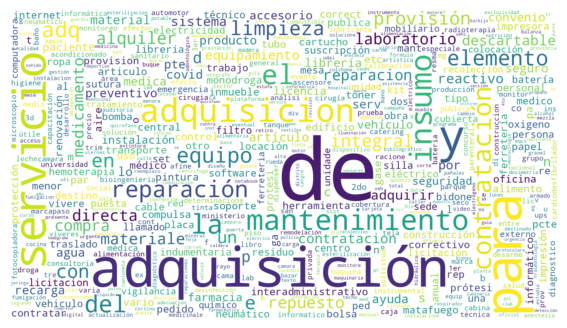

In [7]:
table1 = str.maketrans(string.punctuation,' '*len(string.punctuation)) #tabla para eliminar signos de puntuacion

#Se pasa todo a minúsculas
i=0
for sentence in df_fil['objeto']:    
    df_fil.loc[i,'objeto'] = str(df_fil['objeto'][i]).lower()
    i+=1

i=0
for sentence in df_fil['objeto']:    
    df_fil.loc[i,'objeto'] = str(df_fil['objeto'][i]).translate(table1) #elimino signos de puntuacion
    i+=1

#Después de eliminar algunas palabras quedan espacios dobles o triples. Se Cambia a un espacio:
df_fil['objeto'] = df_fil['objeto'].replace('   ',' ')
df_fil['objeto'] = df_fil['objeto'].replace('  ',' ')

#Ahora vemos cómo va quedando:
print(df_fil['objeto'][:100])
plot_cloudword(df_fil['objeto'],'palabras_min_no_punt')

Ahora que tenemos todo en minúsculas y sin signos, eliminamos tildes, artículos, preposiciones y otras palabras que creemos no aportan información relevante al pliego:

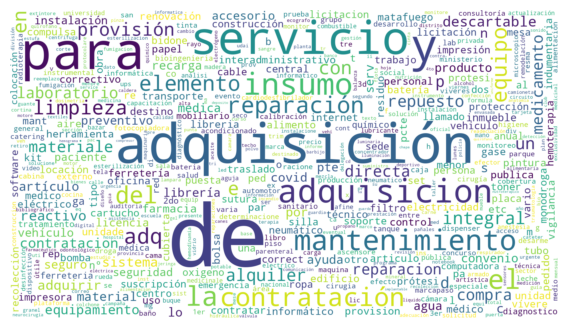

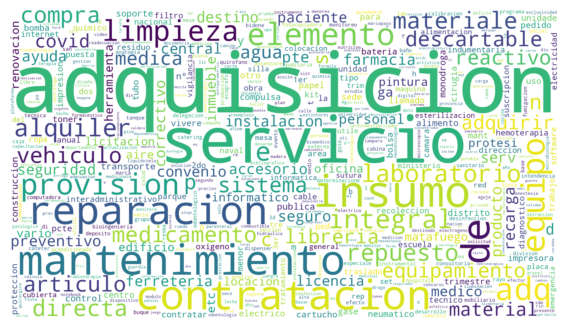

In [8]:
articulos = ['el','la','los','las','un','uno','una','unos','unas','lo','al','del']
preposiciones = ['a', 'ante', 'bajo', 'cabe', 'con', 'contra', 'de', 'desde', 'durante',
                 'en', 'entre', 'hacia', 'hasta', 'mediante', 'para', 'por', 'segun', 
                 'sin', 'so', 'sobre', 'tras', 'versus', 'via']
otras = ['y','su','de','sus','n°']

df_fil.reset_index(drop=True,inplace=True)

#print(df_fil['objeto'][:1000])
plot_cloudword(df_fil['objeto'],'palabras_min_no_tildes')

#Remuevo tildes y elimino palabras y algunos signos que no se eliminaron antes en un solo loop:
i=0
for sentence in df_fil['objeto']:  
    #Saco tildes, puntos suspensivos y el caracter de grado
    sent = str(sentence)   # variable a analizar
    if "á" in sent:
        df_fil.loc[i,'objeto'] = df_fil.loc[i,'objeto'].replace('á','a')
    if "é" in sent:
        df_fil.loc[i,'objeto'] = df_fil.loc[i,'objeto'].replace('é','e')
    if "í" in sent:
        df_fil.loc[i,'objeto'] = df_fil.loc[i,'objeto'].replace('í','i')
    if "ó" in sent:
        df_fil.loc[i,'objeto'] = df_fil.loc[i,'objeto'].replace('ó','o')
    if "ú" in sent:
        df_fil.loc[i,'objeto'] = df_fil.loc[i,'objeto'].replace('ú','u')
    if "..." in sent:
        df_fil.loc[i,'objeto'] = df_fil.loc[i,'objeto'].replace('...',' ')
    if "°" in sent:
        df_fil.loc[i,'objeto'] = df_fil.loc[i,'objeto'].replace('°',' ')
    if "¿" in sent:
            df_fil.loc[i,'objeto'] = df_fil.loc[i,'objeto'].replace('¿',' ')

        
    #Empiezo a eliminar palabras que no aportan nada de información.
    #Separo la oración en las palabras constituyentes
    words = df_fil['objeto'][i].split()
 
    #Elimino artículos
    cambie_algo = False
    for art in articulos:
        if art in words:
            words.remove(art)
            cambie_algo = True
    #Elimino preposiciones
    for prep in preposiciones:
        if prep in words:
            words.remove(prep)
            cambie_algo = True
    #Elimino otras
    for otra in otras:
        if otra in words:
            words.remove(otra)
            cambie_algo = True
    if cambie_algo == True:
        df_fil['objeto'][i] = " ".join(words)
    i+=1

#Despues de sacar muchas de estas palabras, puede que queden muchos espacios extra
df_fil['objeto'] = df_fil['objeto'].replace('  ',' ')
df_fil['objeto'] = df_fil['objeto'].replace('   ',' ')
df_fil['objeto'] = df_fil['objeto'].replace('    ',' ')
df_fil['objeto'] = df_fil['objeto'].replace('     ',' ')
    

#Veamos cómo va quedando:
#print(df_fil['objeto'][:1000])
plot_cloudword(df_fil['objeto'],'palabras_min_no_tildes')

In [9]:
df_fil.head()

index      referencia                                             objeto  \
0   9269  412-0168-CME18             provision insumos malla quirurgica etc   
1   9270  414-0175-CME18  serv recoleccion transporte tratamiento dispos...   
2   9271  426-0102-CDI18                                reparacion camillas   
3   9272  417-0222-CME18   policubeta determinacion hemoglobina hemoterapia   
4   9273  410-0127-LPU18  p432 adquisicion insumos servicio laboratorio ...   

       rubro                             agencia    apertura      monto fuente  
0      Salud     CABA 412 - HTAL. COSME ARGERICH  2018-02-14  569304.24   CABA  
1  Depositos        CABA 414 - HTAL. MARIA CURIE  2018-02-14    87500.0   CABA  
2      Salud    CABA 426 - HTAL. PARMENIO PIÑERO  2018-02-14    26200.0   CABA  
3      Salud  CABA 417 - HTAL. PEDRO DE ELIZALDE  2018-02-14    12705.0   CABA  
4      Salud     CABA 410 - HTAL.TEODORO ALVAREZ  2018-02-14  1780678.0   CABA

El dataset va quedando más limpio, aunque hay algunas palabras que se repiten en la cloudword. Aplicamos una lematización a la variable objeto usando la librería `nltk`.

En nlp, 'lematizar' es simplificar una palabra a otra que contenga la información base, como abreviar. Nos sirve para juntar palabras en distintos tiempos y personas por ejemplo.

[nltk_data] Downloading package punkt to
[nltk_data]     /home/gtizeiradelcampillo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gtizeiradelcampillo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/gtizeiradelcampillo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Tokenizamos las oraciones en palabras

0         [provision, insumos, malla, quirurgica, etc]
1    [serv, recoleccion, transporte, tratamiento, d...
2                               [reparacion, camillas]
3    [policubeta, determinacion, hemoglobina, hemot...
4    [p432, adquisicion, insumos, servicio, laborat...
5    [p13, insumos, traumatologia, pte, quispe, ochoa]
6    [jefa, dto, salud, seguridad, traba, ilse, ria...
7       [atosiban, contratacion, menor, pedido, 33832]
8             [adquisicion, suturas, dpto, quirurgico]
9     [adquisicion, reactivos, rickettsia, bartonella]
Name: objeto, dtype: object
****************************************************************************************************
Removemos stopwords (son como las contracciones?)

0         [provision, insumos, malla, quirurgica, etc]
1    [serv, recoleccion, transporte, tratamiento, d...
2                               [reparacion, camillas]
3    [policubeta, determinacion, hemoglobina, hemot...
4    [p432,

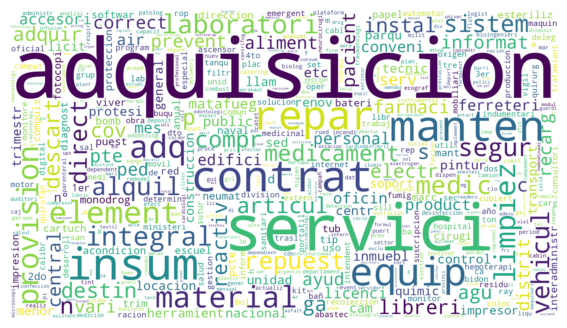

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords') 
nltk.download('wordnet')

#Funcion para lematizar una palabra
def lemmatize_word(word):
    stemmer = SnowballStemmer('spanish')
    return stemmer.stem(word)

df_fil0 = df_fil.copy()

print('Tokenizamos las oraciones en palabras')
print()
df_fil0['objeto'] = df_fil0['objeto'].apply(word_tokenize)
print(df_fil0['objeto'][:10])
print('*'*100)
print('Removemos stopwords (son como las contracciones?)')
print()
stop_words = set(stopwords.words('spanish'))
df_fil0['objeto'] = df_fil0['objeto'].apply(lambda words: [word for word in words if word not in stop_words])
print(df_fil0['objeto'][:10])
print('*'*100)
print('Aplicamos lematización a cada palabra')
print()
df_fil0['objeto'] = df_fil0['objeto'].apply(lambda words: [lemmatize_word(word) for word in words])
print(df_fil0['objeto'][:10])
print('*'*100)

# Unimos las palabras lematizadas en cada oración en otro dataset para ver cómo queda:
df_dum = df_fil0['objeto'].apply(lambda words: ' '.join(words))
#--------------------------------------------------------------
#Vemos cómo va quedando:
print(df_dum[:10])
plot_cloudword(df_dum,'palabras_min_no_tildes')

veamos las distribución de palabras. En particular nos interesa qué porcentaje de los datos
ocupan las palabras más frecuentes.

In [11]:
df_fil0.head()

index      referencia                                             objeto  \
0   9269  412-0168-CME18             [provision, insum, mall, quirurg, etc]   
1   9270  414-0175-CME18  [serv, recoleccion, transport, tratamient, dis...   
2   9271  426-0102-CDI18                                    [repar, camill]   
3   9272  417-0222-CME18      [policubet, determin, hemoglobin, hemoterapi]   
4   9273  410-0127-LPU18  [p432, adquisicion, insum, servici, laboratori...   

       rubro                             agencia    apertura      monto fuente  
0      Salud     CABA 412 - HTAL. COSME ARGERICH  2018-02-14  569304.24   CABA  
1  Depositos        CABA 414 - HTAL. MARIA CURIE  2018-02-14    87500.0   CABA  
2      Salud    CABA 426 - HTAL. PARMENIO PIÑERO  2018-02-14    26200.0   CABA  
3      Salud  CABA 417 - HTAL. PEDRO DE ELIZALDE  2018-02-14    12705.0   CABA  
4      Salud     CABA 410 - HTAL.TEODORO ALVAREZ  2018-02-14  1780678.0   CABA

In [12]:
entire_words = "".join(' '+item for item in df_dum) #el espacio ' '+item es fundamental para que no pegue palabras
list0 = entire_words.split()
df_dum2 = pd.DataFrame(list0,columns=['palabras'])

counts = df_dum2.value_counts()
print(counts[:1000])
nwords = len(dfdf_dum2)
print('cantidad de palabras en monto:',nwords)
print('cantidad de palabras distintas:',len(counts))
print('las 1000 palabras más frecuentes son el '+str(round(np.sum(counts[:1000])/nwords*100,2))+'% del total')
print('las 2000 palabras más frecuentes son el '+str(round(np.sum(counts[:2000])/nwords*100,2))+'% del total')
print('las 5000 palabras más frecuentes son el '+str(round(np.sum(counts[:5000])/nwords*100,2))+'% del total')
print('las 10000 palabras más frecuentes son el '+str(round(np.sum(counts[:10000])/nwords*100,2))+'% del total')
print('las 20000 palabras más frecuentes son el '+str(round(np.sum(counts[:20000])/nwords*100,2))+'% del total')


palabras         
adquisicion          30074
servici              17304
insum                 6298
contrat               6142
manten                6042
repar                 5326
equip                 5167
adq                   3089
element               2979
provision             2863
material              2741
limpiez               2552
laboratori            2282
integral              2153
segur                 2061
medic                 2001
n                     1955
vehicul               1893
alquil                1813
sistem                1754
repuest               1710
destin                1690
direct                1642
compr                 1639
19                    1529
medicament            1493
2021                  1474
cov                   1463
distrit               1414
descart               1404
mes                   1398
articul               1373
central               1349
2                     1344
reactiv               1262
s                     1253
instal    

Seguimos viendo de forma general la distribución de palabras que hay en la variable **rubro**, viendo las primeras entradas del dataset para tener una idea. 

Al igual que en objeto, podemos observar que:
* Las entradas están llenas de signos de puntuación,
* hay muchos artículos y conectores,
* muchas palabras repetidas por estar algunas en mayúsculas, otras en minúsculas, y otras pueden estar abreviadas.
* muchas palabras son las mismas y sólo cambian si están en singular y plural.

Para tener una idea más detallada, usamos la librería `wordcloud`:

0                                                  Salud
1                                              Depositos
2                                                  Salud
3                                                  Salud
4                                                  Salud
5                                                  Salud
6              Textil, Confecci&#243;n y Calzado , Salud
7                                                  Salud
8                                                  Salud
9                                                  Salud
10                                                 Salud
11                                             Servicios
12                                                 Salud
13                                                 Salud
14                                             Servicios
15     Cultura, Deporte y Recreaci&#243;n, Juegos Ol&...
16                                          Construccion
17                             

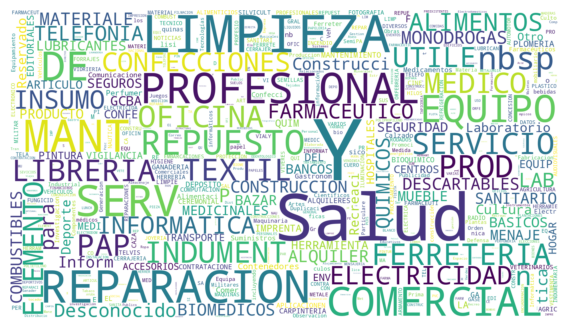

In [13]:
import string
import wordcloud

#Defino una función para plotear cloudwords:
def plot_cloudword(data,name):
    entire_words = "".join(item for item in str(data))
    fig=plt.figure(figsize=(10,4))
    ax=fig.add_subplot(111)
    wc = wordcloud.WordCloud(collocations=False,background_color="white",max_words=500,
                          max_font_size=300,
                          width=1920, 
                          height=1080,).generate(entire_words)
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")
    ax.margins(x=0, y=0)
    plt.savefig(name,dpi=300)
#-------------------------------------------------------------------

print(df_fil0['rubro'][:1000])
plot_cloudword(df_fil0['rubro'],'palabras_inicio')

Veamos cuántas palabras distintas hay en rubro en el dataset:

In [14]:
entire_words = "".join(item for item in df_fil0['rubro'])
list0 = entire_words.split()
dfdf_dum2 = pd.DataFrame(list0,columns=['palabras'])
counts = dfdf_dum2.value_counts()
nwords = len(dfdf_dum2)
print('cantidad de palabras en rubro:',nwords)
print('cantidad de palabras distintas:',len(counts))

cantidad de palabras en rubro: 190369
cantidad de palabras distintas: 13062


Limpiamos la variable **rubro** pasando todas las palabras a minúsculas. También cambiamos algunos espacios dobles o triples por espacios simples. Al hacer esto, pueden quedar espacios dobles o triples. Convertimos todo a espacios simples:

0                                           salud
1                                       depositos
2                                           salud
3                                           salud
4                                           salud
5                                           salud
6                 textil confeccion calzado salud
7                                           salud
8                                           salud
9                                           salud
10                                          salud
11                                      servicios
12                                          salud
13                                          salud
14                                      servicios
15    cultura deporte recreacion juegosol impicos
16                                   construccion
17                           construccion   salud
18                                          salud
19                                      servicios


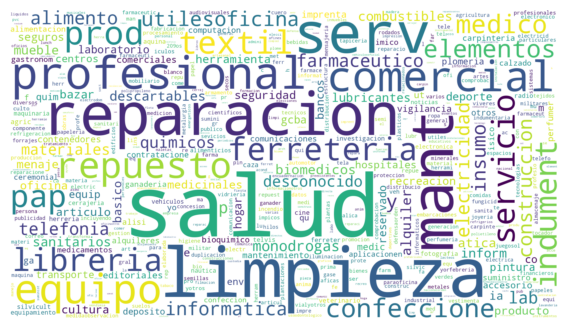

In [21]:
#dfilcheck = df_fil0.copy()
#print(dfilcheck['rubro'][:50])

table_1 = str.maketrans(string.punctuation,' '*len(string.punctuation)) #tabla para eliminar signos de puntuacion

#Paso todo a minúsculas
i=0
for sentence in df_fil0['rubro']:    
    df_fil0.loc[i,'rubro'] = str(df_fil0['rubro'][i]).lower()
    i+=1

i=0
for sentence in df_fil0['rubro']:    
    df_fil0.loc[i,'rubro'] = str(df_fil0['rubro'][i]).translate(table_1) #elimino signos de puntuacion
    i+=1

#a veces, después de eliminar algunas palabras quedan espacios dobles o triples. Cambio a un espacio:
df_fil0['rubro'] = df_fil0['rubro'].replace('   ',' ')
df_fil0['rubro'] = df_fil0['rubro'].replace('  ',' ')
reemplazos = {
    " 225 ": "a",
    " 233 ": "e",
    " 237 ": "i",
    " 243 ": "o",
    " 250 ": "u",
    " nbsp ": " ",
    " o": "o",
    "deoficina": "oficina",
}
df_fil0['rubro'] = df_fil0['rubro'].replace(reemplazos, regex=True)

#veamos cómo va quedando:
print(df_fil0['rubro'][:50])
plot_cloudword(df_fil0['rubro'],'palabras_min_no_punt')


Ahora que tenemos todo en minúsculas y sin signos en **rubro**, eliminamos tildes, artículos, preposiciones y otras palabras que creemos no aportan información relevante al pliego:

In [16]:
df_fil0.head()

index      referencia                                             objeto  \
0   9269  412-0168-CME18             [provision, insum, mall, quirurg, etc]   
1   9270  414-0175-CME18  [serv, recoleccion, transport, tratamient, dis...   
2   9271  426-0102-CDI18                                    [repar, camill]   
3   9272  417-0222-CME18      [policubet, determin, hemoglobin, hemoterapi]   
4   9273  410-0127-LPU18  [p432, adquisicion, insum, servici, laboratori...   

       rubro                             agencia    apertura      monto fuente  
0      salud     CABA 412 - HTAL. COSME ARGERICH  2018-02-14  569304.24   CABA  
1  depositos        CABA 414 - HTAL. MARIA CURIE  2018-02-14    87500.0   CABA  
2      salud    CABA 426 - HTAL. PARMENIO PIÑERO  2018-02-14    26200.0   CABA  
3      salud  CABA 417 - HTAL. PEDRO DE ELIZALDE  2018-02-14    12705.0   CABA  
4      salud     CABA 410 - HTAL.TEODORO ALVAREZ  2018-02-14  1780678.0   CABA

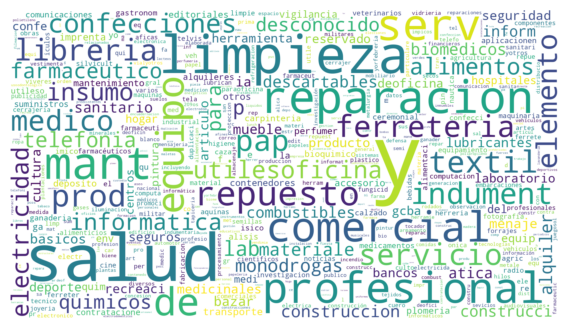

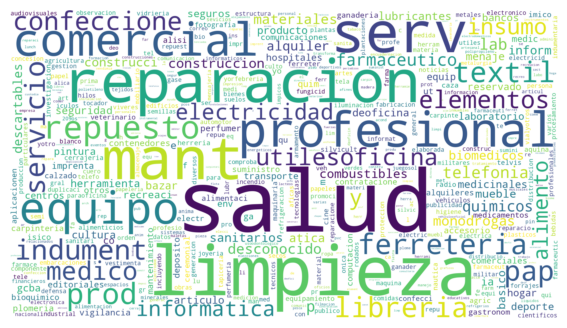

In [17]:
articulos = ['el','la','los','las','un','uno','una','unos','unas','lo','al','del']
preposiciones = ['a', 'ante', 'bajo', 'cabe', 'con', 'contra', 'de', 'desde', 'durante',
                 'en', 'entre', 'hacia', 'hasta', 'mediante', 'para', 'por', 'segun', 
                 'sin', 'so', 'sobre', 'tras', 'versus', 'via']
otras = ['y','su','de','sus','n°']

df_fil0.reset_index(drop=True,inplace=True)
plot_cloudword(df_fil0['rubro'],'palabras_min_no_tildes')

# remuevo tildes y elimino palabras y algunos signos que no se eliminaron antes en un solo loop:
i=0
for sentence in df_fil0['rubro']:  
    #aca saco tildes, puntos suspensivos y el caracter de grado
    sent = str(sentence)   # variable a analizar
    if "á" in sent:
        df_fil0.loc[i,'rubro'] = df_fil0.loc[i,'rubro'].replace('á','a')
    if "é" in sent:
        df_fil0.loc[i,'rubro'] = df_fil0.loc[i,'rubro'].replace('é','e')
    if "í" in sent:
        df_fil0.loc[i,'rubro'] = df_fil0.loc[i,'rubro'].replace('í','i')
    if "ó" in sent:
        df_fil0.loc[i,'rubro'] = df_fil0.loc[i,'rubro'].replace('ó','o')
    if "ú" in sent:
        df_fil0.loc[i,'rubro'] = df_fil0.loc[i,'rubro'].replace('ú','u')
    if "..." in sent:
        df_fil0.loc[i,'rubro'] = df_fil0.loc[i,'rubro'].replace('...',' ')
    if "°" in sent:
        df_fil0.loc[i,'rubro'] = df_fil0.loc[i,'rubro'].replace('°',' ')
    if "¿" in sent:
            df_fil0.loc[i,'rubro'] = df_fil0.loc[i,'rubro'].replace('¿',' ')

        
    #Empiezo a eliminar palabras que no aportan nada de información.
    #Separo la oración en las palabras constituyentes
    words = df_fil0['rubro'][i].split()
 
    #Elimino artículos
    cambie_algo = False
    for art in articulos:
        if art in words:
            words.remove(art)
            cambie_algo = True
    #Elimino preposiciones
    for prep in preposiciones:
        if prep in words:
            words.remove(prep)
            cambie_algo = True
    #Elimino otras
    for otra in otras:
        if otra in words:
            words.remove(otra)
            cambie_algo = True
    if cambie_algo == True:
        df_fil0['rubro'][i] = " ".join(words)
    i+=1

#Despues de sacar muchas de estas palabras, puede que queden muchos espacios extra
df_fil0['rubro'] = df_fil0['rubro'].replace('  ',' ')
df_fil0['rubro'] = df_fil0['rubro'].replace('   ',' ')
df_fil0['rubro'] = df_fil0['rubro'].replace('    ',' ')
df_fil0['rubro'] = df_fil0['rubro'].replace('     ',' ')
    

#Vemos cómo va quedando:
#print(df_fil['objeto'][:1000])
plot_cloudword(df_fil0['rubro'],'palabras_min_no_tildes')

In [18]:
df_fil0.head()

index      referencia                                             objeto  \
0   9269  412-0168-CME18             [provision, insum, mall, quirurg, etc]   
1   9270  414-0175-CME18  [serv, recoleccion, transport, tratamient, dis...   
2   9271  426-0102-CDI18                                    [repar, camill]   
3   9272  417-0222-CME18      [policubet, determin, hemoglobin, hemoterapi]   
4   9273  410-0127-LPU18  [p432, adquisicion, insum, servici, laboratori...   

       rubro                             agencia    apertura      monto fuente  
0      salud     CABA 412 - HTAL. COSME ARGERICH  2018-02-14  569304.24   CABA  
1  depositos        CABA 414 - HTAL. MARIA CURIE  2018-02-14    87500.0   CABA  
2      salud    CABA 426 - HTAL. PARMENIO PIÑERO  2018-02-14    26200.0   CABA  
3      salud  CABA 417 - HTAL. PEDRO DE ELIZALDE  2018-02-14    12705.0   CABA  
4      salud     CABA 410 - HTAL.TEODORO ALVAREZ  2018-02-14  1780678.0   CABA

Tokenizamos las oraciones en palabras

0                                   [salud]
1                               [depositos]
2                                   [salud]
3                                   [salud]
4                                   [salud]
5                                   [salud]
6    [textil, confecci, on, calzado, salud]
7                                   [salud]
8                                   [salud]
9                                   [salud]
Name: rubro, dtype: object
****************************************************************************************************
Removemos stopwords (son como las contracciones?)

0                                   [salud]
1                               [depositos]
2                                   [salud]
3                                   [salud]
4                                   [salud]
5                                   [salud]
6    [textil, confecci, on, calzado, salud]
7                                 

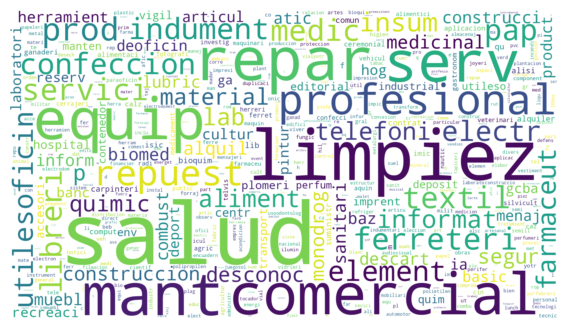

In [19]:
def lemmatize_word(word):
    stemmer = SnowballStemmer('spanish')
    return stemmer.stem(word)


df_fil_0 = df_fil0.copy()

print('Tokenizamos las oraciones en palabras')
print()
df_fil_0['rubro'] = df_fil_0['rubro'].apply(word_tokenize)
print(df_fil_0['rubro'][:10])
print('*'*100)
print('Removemos stopwords (son como las contracciones?)')
print()
stop_words = set(stopwords.words('spanish'))
df_fil_0['rubro'] = df_fil_0['rubro'].apply(lambda words: [word for word in words if word not in stop_words])
print(df_fil_0['rubro'][:10])
print('*'*100)
print('Aplicamos lematización a cada palabra')
print()
df_fil_0['rubro'] = df_fil_0['rubro'].apply(lambda words: [lemmatize_word(word) for word in words])
print(df_fil_0['rubro'][:10])
print('*'*100)
# Unimos las palabras lematizadas en cada oración en otro dataset para ver cómo queda:
df_dum_rub = df_fil_0['rubro'].apply(lambda words: ' '.join(words))
#--------------------------------------------------------------
#Vemos cómo va quedando:
print(df_dum_rub[:10])
plot_cloudword(df_dum_rub,'palabras_min_no_tildes')

Extraemos el nuevo dataframe para continuar el TP3

In [22]:
df_fil_0.to_csv('Mentoria_dataset_tp2.csv', index=False)